# Recommender systems

In recommender systems, we either assume:

- that we know the **rating** that some user gave to some item (for example, "Joseph Marchand gave 4 stars over 5 to the Suzume movie"), this is called *explicit feedback*
- that we only observe the user interacting with items in a sequence (for example, which songs are played on Spotify or YouTube in which order), but **no ratings**; this is called *implicit feedback*.

In this homework, you will build models that optimize either the first setting or the second one.

First, execute all cells to ensure you have the necessary packages.

## Part 1: Explicit feedback

In [1]:
# !pip install spotlight  # Used as baseline and for preparing datasets
import torch
from torch import nn
import numpy as np
from spotlight.cross_validation import random_train_test_split
from spotlight.datasets.movielens import get_movielens_dataset
from spotlight.evaluation import rmse_score
from spotlight.factorization.explicit import ExplicitFactorizationModel
from tqdm import tqdm

from matplotlib import pyplot as plt

In [2]:
dataset = get_movielens_dataset(variant='100K')
print(dataset)

train, test = random_train_test_split(dataset)

<Interactions dataset (944 users x 1683 items x 100000 interactions)>


In [3]:
train.__dict__

{'num_users': 944,
 'num_items': 1683,
 'user_ids': array([655, 385, 870, ..., 493, 693, 798]),
 'item_ids': array([1560, 1071,  332, ...,   61,  604,   82]),
 'ratings': array([2., 4., 2., ..., 4., 3., 4.], dtype=float32),
 'timestamps': array([887429136, 879448426, 879982785, ..., 884131263, 875484480,
        875915855]),
 'weights': None}

Users are numbered from 1 to 943 and items are numbered from 1 to 1682.  
Number of users is set to 944 and number of items is set to 1683 to avoid off-by-one errors.

In [4]:
print(f"As an example, user {train.user_ids[0]} gave {train.ratings[0]} stars to item {train.item_ids[0]}.")

As an example, user 655 gave 2.0 stars to item 1560.


In [5]:
len(train) / len(dataset)

0.8

Train / test is a 80:20 split. We should predict in the test set what is the rating for an unseen (user, item) pair: it is a regression problem.

### NOTE ###
_____
This model is juste a score mapping between users and items, it do not take into account any history.

Istead of storing a big n_users x n_items matrix, it stores two small n_users x c and n_items x c matrix used to make dot products on run time.

In [6]:
explicit_model = ExplicitFactorizationModel(n_iter=2)
losses = explicit_model.fit(train)

rmse_score(explicit_model, test)

0.98261696

A first exercise is to reproduce this metric. We will do it together in order to make sure that we talk about the same thing, i.e.:

$$\text{RMSE}(y^*, y) = \sqrt{\frac1N \sum_{i = 1}^N (y^*_i - y_i)^2}$$

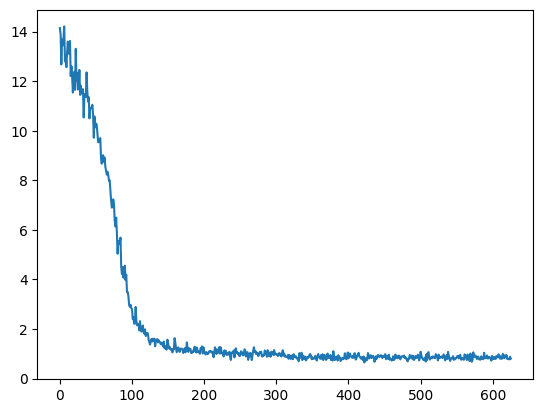

In [7]:
plt.plot(range(len(losses)), losses)
plt.show()

In [8]:
def our_rmse(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean() ** 0.5

In [9]:
explicit_y_pred = explicit_model.predict(test.user_ids, test.item_ids)
explicit_y_pred

array([3.3740337, 2.7116828, 3.60721  , ..., 3.4970596, 3.55511  ,
       4.311011 ], dtype=float32)

In [10]:
X_train = torch.LongTensor(np.column_stack((train.user_ids, train.item_ids)))
X_test = torch.LongTensor(np.column_stack((test.user_ids, test.item_ids)))
y_train = torch.Tensor(train.ratings)
y_test = torch.Tensor(test.ratings)

X_train[:5], y_train[:5]

(tensor([[ 655, 1560],
         [ 385, 1071],
         [ 870,  332],
         [  18,  968],
         [ 230,   99]]),
 tensor([2., 4., 2., 3., 3.]))

In [11]:
our_rmse(y_test, explicit_y_pred)

tensor(0.9826)

> *Yes, I got the same thing.*

— The Social Network

In [12]:
our_rmse(y_test, torch.ones_like(y_test) * y_train.mean())  # Simplest baseline

tensor(1.1245)

In [13]:
tr_mean = y_train.mean()
te_mean = y_test.mean()
tr_std = y_train.std()
te_std = y_test.std()

print(f"Train mean: {tr_mean:.3f}, std: {tr_std:.3f}")
print(f"Test mean: {te_mean:.3f}, std: {te_std:.3f}")

Train mean: 3.528, std: 1.126
Test mean: 3.539, std: 1.124


In [14]:
BATCH_SIZE = 256
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [15]:
class CollaborativeFilteringModel(nn.Module):
    """
    Recommender system for explicit feedback
    """
    def __init__(self, nb_users, nb_items, embedding_size):
        super().__init__()

        self.embedding_size = embedding_size

        self.user_embedding = nn.Embedding(nb_users, embedding_size)
        self.user_embedding.weight.data.normal_(0, 1.0 / embedding_size)

        self.item_embedding = nn.Embedding(nb_items, embedding_size)
        self.item_embedding.weight.data.normal_(0, 1.0 / embedding_size)
        
        self.user_bias = nn.Embedding(nb_users, 1)
        self.user_bias.weight.data.normal_(0, 1.0 / 1)

        self.item_bias = nn.Embedding(nb_items, 1)
        self.item_bias.weight.data.normal_(0, 1.0 / 1)

    def forward(self, x):
        users = x[:, 0]
        items = x[:, 1]

        u = self.user_embedding(users)
        v = self.item_embedding(items)
        
        u_b = self.user_bias(users)
        v_b = self.item_bias(items)

        return (u * v).sum(1) + u_b + v_b

EMBEDDING_SIZE = 20
collab_model = CollaborativeFilteringModel(train.num_users, train.num_items, EMBEDDING_SIZE)

In [16]:
N_EPOCHS = 2
LEARNING_RATE = 1e-2

In [17]:
def fit_fct(model, train_iter, X_test, y_test, loss_function=nn.MSELoss(), lr=LEARNING_RATE, n_epochs=N_EPOCHS):
    # You can also check what happens where there is no weight decay i.e. no L2 regularization
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0)

    train_losses = []
    test_losses = []
    for epoch in tqdm(range(n_epochs)):
        # Your code here, write a training loop and plot train and test RMSE.
        # Don't forget that the loss is the mean squared error.
        # If you want to display RMSE, you need to take its square root.
        
        for x, y in train_iter:
            optimizer.zero_grad()
            y_pred = model(x)
            loss = loss_function(y_pred, y)
            loss.backward()
            optimizer.step()
            train_losses.append(torch.sqrt(loss).item())
        
        with torch.no_grad():
            y_pred = model(X_test)
            loss = loss_function(y_pred, y_test)
            test_losses.append(torch.sqrt(loss).item())

    if X_test is None:
        return train_losses
    return train_losses, test_losses

  0%|          | 0/2 [00:00<?, ?it/s]c:\Users\Grégoire\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Grégoire\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Grégoire\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([20000])) that is different to the input s

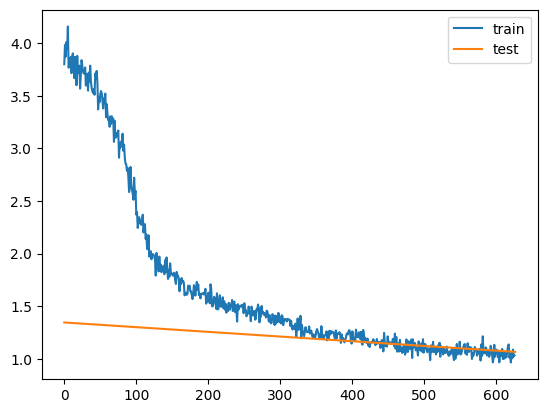

In [18]:
train_losses, test_losses = fit_fct(collab_model, train_iter, X_test, y_test)

train_x = np.arange(len(train_losses))
test_x = np.linspace(0, len(train_losses), len(test_losses))

plt.plot(train_x, train_losses, label='train')
plt.plot(test_x, test_losses, label='test')
plt.legend()
plt.show()

In [19]:
@torch.no_grad()
def test(model, data_loader):
  model.eval()
  total_loss = 0
  total_samples = 0
  for x , ratings in data_loader:
    predictions = model(x)
    loss = our_rmse(predictions, ratings.float())
    total_loss += loss.item()
    total_samples += 1
  return total_loss / total_samples

test(collab_model, test_iter)

1.065113815325725

## Part 2: Implicit feedback

In this section, we do not observe numerical ratings anymore, just sequences of items.

In [20]:
from spotlight.cross_validation import user_based_train_test_split
from spotlight.evaluation import sequence_mrr_score
from spotlight.sequence.implicit import ImplicitSequenceModel

# If you want to debug on a smaller dataset first, you can use this
'''from spotlight.datasets.synthetic import generate_sequential
dataset = generate_sequential(num_users=100,
                              num_items=1000,
                              num_interactions=10000,
                              concentration_parameter=0.01,
                              order=3)'''

# Otherwise we reuse Movielens
train, test = user_based_train_test_split(dataset)

train = train.to_sequence()
test = test.to_sequence()

implicit_model = ImplicitSequenceModel(n_iter=3,
                              representation='pooling',
                              loss='pointwise')
implicit_model.fit(train)

sequence_mrr_score(implicit_model, test).mean()

0.046179748491096004

In [21]:
train

<Sequence interactions dataset (8614 sequences x 10 sequence length)>

In [22]:
train.__dict__

{'sequences': array([[ 321,  260,  329, ...,  320,  317,  181],
        [ 322,  330,  264, ...,  328,  348,  327],
        [ 332,  307,  271, ...,  335,  323,  349],
        ...,
        [ 928,   24,  274, ..., 1047,  111,  284],
        [ 763,   50,  412, ...,  685,  471,  405],
        [   0,    0,   64, ..., 1067,  127,  508]]),
 'user_ids': array([  3,   3,   3, ..., 943, 943, 943]),
 'max_sequence_length': 10,
 'num_items': 1683}

In [23]:
train.__dict__['sequences'].shape

(8614, 10)

The `train` dataset contains 8000+ sequences of length 10 representing the movies seen, IDs between 1 and 1683. 

We do have access to user IDs but we will not need them. Here, the maximum length of a sequence is 10, so sequences have been split to be of max size 10. Sequences having less than 10 items are padded with 0s.

The objective becomes, given the first 9 items, predict the 10th item (classification). In order to have a better comparison of models, we are mainly interested in a ranking metric: in the ranked movies by probability, where was the correct answer? Mean reciprocal rank is, for $N$ samples:

$${\text{MRR}}={\frac {1}{N}}\sum _{{i=1}}^{{N}}{\frac {1}{{\text{rank}}_{i}}}$$

where $\text{rank}_i$ is a number between 1 and 1683, the number of items, which represents the rank of the expected answer, where movies are ranked by decreasing probability. The MRR is between 0 and 1 and higher is better (when all ranks are 1).

Again, we will first attempt to reproduce the metric.

In [24]:
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.preprocessing import OneHotEncoder
from scipy.special import softmax

ohe = OneHotEncoder(categories=[list(range(train.num_items))])
target = ohe.fit_transform(test.sequences[:, [-1]]).toarray()

target.shape  # The target is a one-hot encoding of correct answers for each sample

(1825, 1683)

In [25]:
implicit_y_pred = []
for seq in test.sequences:
    implicit_y_pred.append(softmax(implicit_model.predict(seq[:-1])))
implicit_y_pred = np.array(implicit_y_pred)
implicit_y_pred.round(2)  # The predictions are probabilities for each sample x item

array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.01, 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.01, 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.04, 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]], dtype=float32)

In [26]:
# This function is actually more generic as it can also consider multilabel classification
# i.e. several correct answers for a sample. In our case (1 correct answer per sample) it is equal to MRR.
label_ranking_average_precision_score(target, implicit_y_pred)

0.04617974849109625

### NOTE ###
_____
C'est pourris 0.04 de MRR, ça fait un rang moyen de 25, donc au mieux la probabilité moyenne est de 0.04 sur le vrai film.

On va regarder la vraie probabilité moyenne.

In [27]:
# mean probability of the correct answer

targ_idx = np.argmax(target, axis=1)
implicit_y_pred[:, targ_idx].mean()

0.0020949424

Abyssale :o

Again, we got the same number. We now show the metric for two simple baselines:

In [28]:
from collections import Counter

item_counts = Counter(train.sequences[:, -1])
most_popular_item = item_counts.most_common()[0][0]
most_popular_baseline = np.zeros_like(target)
most_popular_baseline[:, most_popular_item] = 1
label_ranking_average_precision_score(target, most_popular_baseline)

0.006617992983827154

In [29]:
popularity = np.zeros(train.num_items)
for item_id, count in item_counts.items():
    popularity[item_id] = count
popularity = softmax(popularity)
popularity_baseline = np.tile(popularity, (len(target), 1))  # Repeat for each test sample

label_ranking_average_precision_score(target, popularity_baseline)

0.025881157091307082

You should now write a model / module that takes a batch of sequences of max 9 elements and should predict the next one.

You can either take:
- a sequential approach, i.e. RNN / LSTM / GRU or a transformer like [minGPT](https://github.com/karpathy/minGPT) (which is more complex; please start simple);
- or a non-sequential one like [CBOW](https://lilianweng.github.io/posts/2017-10-15-word-embedding/#context-based-continuous-bag-of-words-cbow).

Loss can either be cross-entropy (simple), [noise contrastive estimation, or negative sampling](https://lilianweng.github.io/posts/2017-10-15-word-embedding/#noise-contrastive-estimation-nce).

The goal is to have comparable or better MRR than 0.04.

P. S. – In order to ignore index 0 you can use `padding_idx` in [nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) or the function [`masked_select()`](https://pytorch.org/docs/stable/generated/torch.masked_select.html) for RNN.

In [30]:
from Transformer import Transformer, Config

In [31]:
def cross_entropy_loss(logits, tokens):
    log_probs = torch.log_softmax(logits, dim=-1)
    pred_log_probs = torch.gather(log_probs, 2, tokens.unsqueeze(-1)).squeeze(-1)
    return -pred_log_probs.mean()

In [32]:
X_train = torch.LongTensor(train.sequences[:, :-1])
y_train = torch.LongTensor(train.sequences[:, 1:])

X_test = torch.LongTensor(test.sequences[:, :-1])
y_test = torch.LongTensor(test.sequences[:, 1:])

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [33]:
nb_movies = train.num_items
seq_length = train.max_sequence_length

cfg = Config()

cfg.d_residual: int = 32
cfg.debug: bool = False
cfg.layer_norm_eps: float = 1e-5
cfg.d_vocab: int = nb_movies
cfg.init_range: float = None
cfg.max_length: int = seq_length
d_mlp: int = 4 * cfg.d_residual
cfg.d_head: int = 8
cfg.n_heads: int = 4
cfg.n_layers: int = 4

transformer_model = Transformer(cfg)

100%|██████████| 10/10 [00:57<00:00,  5.71s/it]


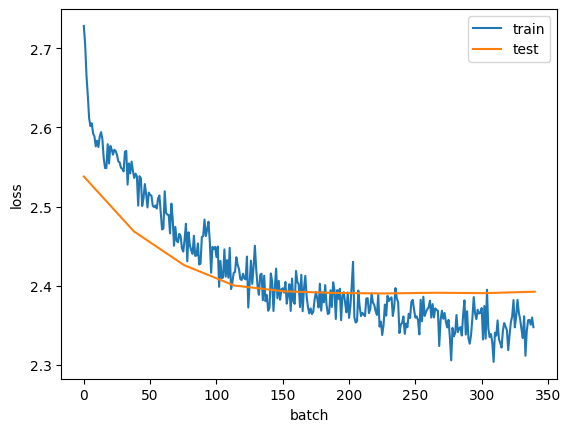

In [34]:
train_losses, test_losses = fit_fct(transformer_model, train_iter, X_test, y_test, loss_function=cross_entropy_loss, lr = 1e-2, n_epochs=10)

train_x = np.arange(len(train_losses))
test_x = np.linspace(0, len(train_losses), len(test_losses))

plt.plot(train_x, train_losses, label='train')
plt.plot(test_x, test_losses, label='test')
plt.xlabel('batch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [35]:
logits = transformer_model(X_test)[:,-1].squeeze(1)
transformer_y_pred = torch.softmax(logits, dim=-1)

label_ranking_average_precision_score(target, transformer_y_pred.detach().numpy())

0.06146145440014181

0.061 > 0.04 => je peux aller dormir en paix :o

(j'ai relancé donc les chiffres sont peut être plus bons)

In [36]:
targ_idx = np.argmax(target, axis=1)
transformer_y_pred[:, targ_idx].mean().item()

0.0017515335930511355

Alors, en fait, la proba moyenne d'avoir la bonne prédiction est moins bonne qu'avec le premier modèle proposé (0.0018 vs 0.0023), donc de ce point de vue mon transformer est moins bien, même si le rang moyen est passé de 25 à 16.

Peut être que le transformer est plus sur de lui par rapport à l'autre modèle, donc quand il a faut, il a faut plus fort.

J'ai bien dormi, et en fait 1/MRR c'est pas du tout le rang moyen, c'est la moyenne harmonique, donc les rangs faibles dominent. Donc c'est nul, on a l'impression qu'il est bon dès qu'il est bon une ou deux fois :o

On va regarder le vrai rang moyen.

In [39]:
def mean_rank(y_pred, target):
    targ_idx = np.argmax(target, axis=1)
    y_perm = np.argsort(y_pred, axis=1)[:, ::-1]
    perm_inv = np.arange(y_pred.shape[1])[y_perm]
    return np.mean(perm_inv[:, targ_idx])

In [40]:
random_y_pred = np.random.rand(*target.shape)
random_y_pred = softmax(random_y_pred)

random_mean_rank = mean_rank(random_y_pred, target)
implicit_mean_rank = mean_rank(implicit_y_pred, target)
most_popular_mean_rank = mean_rank(most_popular_baseline, target)
popularity_mean_rank = mean_rank(popularity_baseline, target)
transformer_mean_rank = mean_rank(transformer_y_pred.detach().numpy(), target)

print(f"Random: {random_mean_rank:.2f}")
print(f"Implicit: {implicit_mean_rank:.2f}")
print(f"Most popular: {most_popular_mean_rank:.2f}")
print(f"Popularity: {popularity_mean_rank:.2f}")
print(f"Transformer: {transformer_mean_rank:.2f}")

Random: 840.71
Implicit: 581.63
Most popular: 608.47
Popularity: 511.27
Transformer: 602.07


C'est pas si étonnant que popularity et most popular soient bons, ils sont fait pour ça, mais c'est étonnant qu'on soit si mauvais... On est à peine mieux que l'aléatoire. Donc d'après la MRR, ça arrive pas trop rarement qu'on ait plutôt raison, et d'après la vraie moyenne, quand on a tord, on a vraiment tord :o